In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
train_masks=pd.read_csv(".\\all\\train.csv")
train_masks.head()


,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


In [3]:
import os
train_ids=next(os.walk(".\\all\\train\\images"))[2]
test_ids=next(os.walk(".\\all\\test\\images"))[2]
train_ids[1:5]


['003c477d7c.png', '00441f1cf2.png', '0050766ae2.png', '005b452274.png']

Using TensorFlow backend.


<PIL.Image.Image image mode=RGB size=101x101 at 0x18027C39A20>
<PIL.Image.Image image mode=RGB size=101x101 at 0x18025B97AC8>
<PIL.Image.Image image mode=RGB size=101x101 at 0x18027CDB278>
<PIL.Image.Image image mode=RGB size=101x101 at 0x18027D42CC0>
<PIL.Image.Image image mode=RGB size=101x101 at 0x18027DBFAC8>
<PIL.Image.Image image mode=RGB size=101x101 at 0x18027E2C2B0>
<PIL.Image.Image image mode=RGB size=101x101 at 0x18027E9CC88>
<PIL.Image.Image image mode=RGB size=101x101 at 0x18027F0BD68>
<PIL.Image.Image image mode=RGB size=101x101 at 0x18027F865C0>
<PIL.Image.Image image mode=RGB size=101x101 at 0x18027FF2438>
<PIL.Image.Image image mode=RGB size=101x101 at 0x1802806C4A8>
<PIL.Image.Image image mode=RGB size=101x101 at 0x180280D2A58>
<PIL.Image.Image image mode=RGB size=101x101 at 0x1802814B128>
<PIL.Image.Image image mode=RGB size=101x101 at 0x180281B8048>
<PIL.Image.Image image mode=RGB size=101x101 at 0x1802822A9B0>


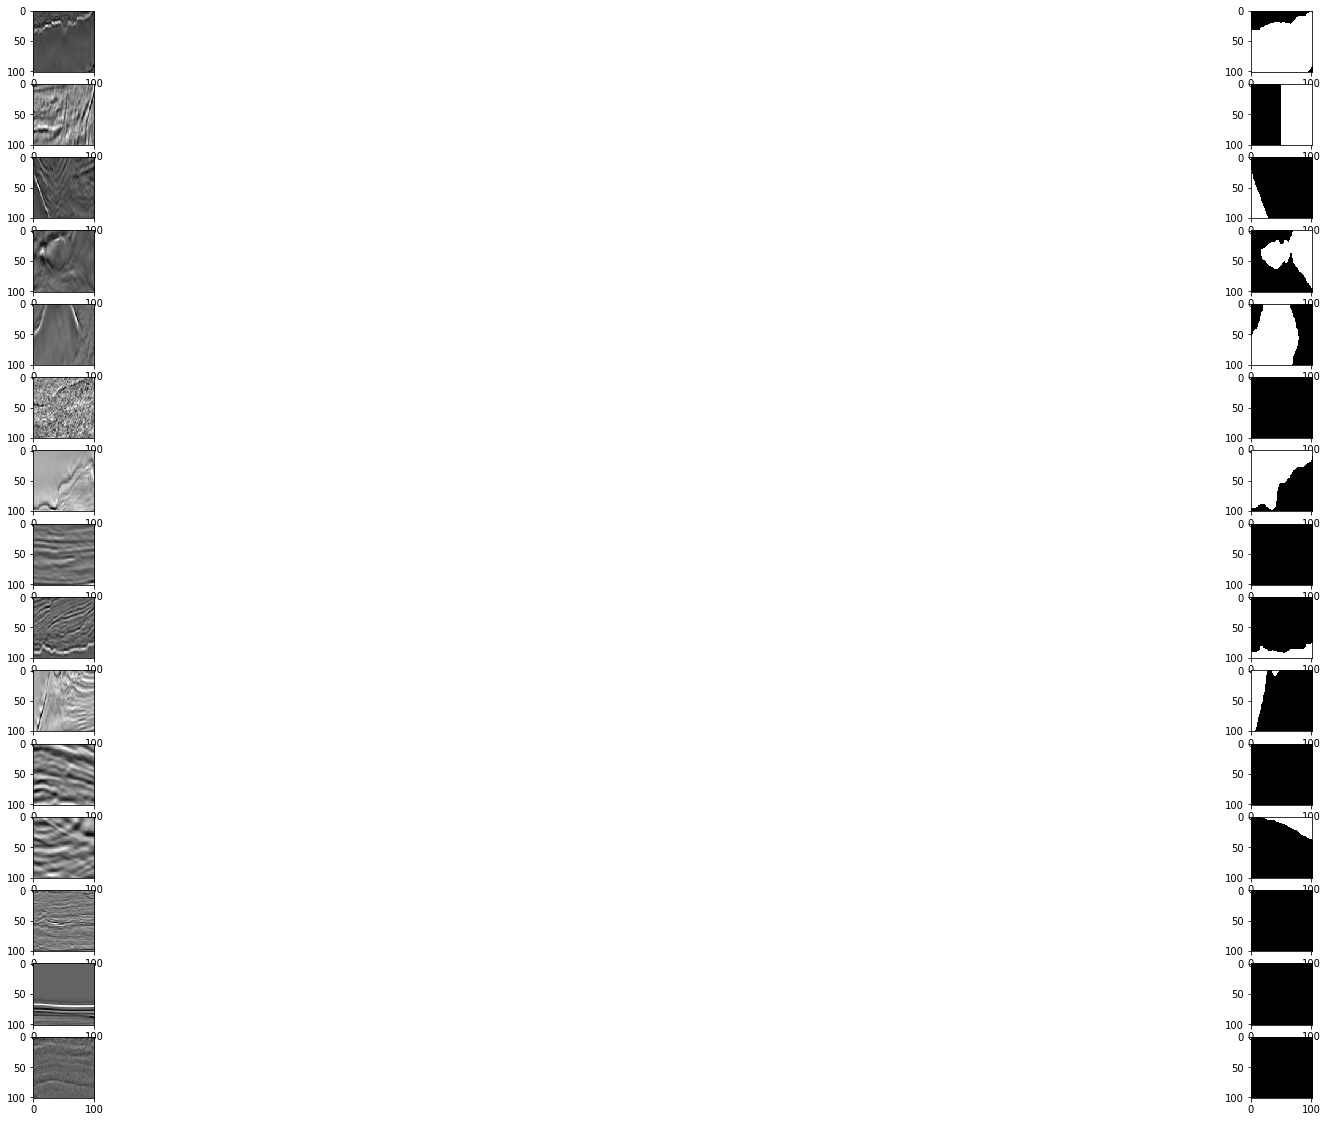

In [4]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
plt.figure(figsize=(40,20))
for i,img_id in enumerate(train_ids[30:45]):
    train_img=image.load_img(".\\all\\train\\images\\"+img_id)
    img_mask=image.load_img(".\\all\\train\\masks\\"+img_id)
    plt.subplot(15,2,(2*i)+1)
    plt.imshow(train_img)
    plt.subplot(15,2,(2*i)+2)
    plt.imshow(img_mask)
    print(img_mask)

In [5]:
from skimage import io
from tqdm import tqdm_notebook as tqdm
all_images=[]
all_image_masks=[]
for i,img_id in enumerate(tqdm(train_ids)):
    img=io.imread(".\\all\\train\\images\\"+img_id,as_gray=False)
    img_mask=io.imread(".\\all\\train\\masks\\"+img_id,as_gray=True)
    #print(img.shape)
    #img=img.reshape([101,101,3])
    #img_mask=img_mask.reshape([101,101,3])
    all_images.append(img)
    all_image_masks.append(img_mask)


In [6]:
#X_train=pd.DataFrame(data=all_images[0:][0:][0:])
x_train=np.array(all_images)
y_train=np.array(all_image_masks,dtype=np.bool)
#X_train=pd.DataFrame(data=x_train)

print(x_train.shape)
print(y_train.shape)
#X_train.shape
#X_train.head()
#x_train.head()

(4000, 101, 101, 3)
(4000, 101, 101)


In [7]:
y_train=y_train.reshape(4000,101,101,1)


In [8]:
y_train.shape

y_train[1][1]


array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [9]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input,Flatten,Dense
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
model_vgg16_conv=VGG16(weights='imagenet',include_top=False)

In [10]:
import tensorflow as tf
from keras import backend as K
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)
def mean_iou_1(y_true,y_pred):
    return(tf.metrics.mean_iou(y_true,y_pred,2))
def mean_iou_2(y_true, y_pred, smooth=1):
    """
    IoU = (|X & Y|)/ (|X or Y|)
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum((y_true,-1) + K.sum(y_pred,-1) - intersection)                  
    return -(intersection + smooth)/( union + smooth)

def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred): #any shape can go

    tresholds = [0.5 + (i*.05)  for i in range(10)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [11]:
from keras.layers import Input,Convolution2D,MaxPooling2D,BatchNormalization,Conv2DTranspose,concatenate,ZeroPadding2D,Lambda
#input=Input(input_shape=(101,101,1))
from keras.models import Model
import tensorflow as tf

#model_vgg16_conv.layers[-1]
#model_vgg16_conv.summary()
_input=Input((101,101,3))
s=Lambda(lambda x:x/255)(_input)
a1=BatchNormalization(axis=1)(s)
a2=Convolution2D(32,(3,3),padding='same',activation='relu')(a1)
a3=BatchNormalization(axis=1)(a2)
a4=Convolution2D(32,(3,3),padding='same',activation='relu')(a3)
a5=MaxPooling2D((3,3))(a4)
#a5=ZeroPadding2D(padding=(1,1))(a5)


a6=Convolution2D(64,(3,3), padding='same',activation='relu')(a5)
a7=BatchNormalization(axis=1)(a6)
a8=Convolution2D(64,(3,3), padding='same',activation='relu')(a7)
a7=BatchNormalization(axis=1)(a8)
a8=Convolution2D(64,(3,3), padding='same',activation='relu')(a7)
a9=MaxPooling2D((3,3))(a8)

a10=Convolution2D(128,(3,3), padding='same',activation='relu')(a9)
a11=BatchNormalization(axis=1)(a10)
a12=Convolution2D(128,(3,3), padding='same',activation='relu')(a11)
a10=Convolution2D(128,(3,3), padding='same',activation='relu')(a12)
a11=BatchNormalization(axis=1)(a10)
a13=MaxPooling2D((3,3))(a12)



b1=Conv2DTranspose(64,(2,2),strides=(3,3),padding='same')(a12)
b2=concatenate([b1,a6],axis=3)
b3=Convolution2D(64,(3,3),padding='same',activation='relu')(b2)
b3=Convolution2D(64,(3,3),padding='same',activation='relu')(b3)


b4=Conv2DTranspose(32,(2,2),strides=(3,3),padding='same')(b3)
b4=ZeroPadding2D(padding=(1,1))(b4)
b5=concatenate([b4,a4])
b6=Convolution2D(8,(3,3),padding='same',activation='relu')(b5)
b7=Convolution2D(8,(3,3),padding='same',activation='relu')(b6)
b8=(Convolution2D(1,(1,1),padding='same',activation='sigmoid'))(b7)

#output=Dense()
#a2=model_vgg16_conv.layers[7](a2)
#a2=model_vgg16_conv.layers[8](a2)

#a2=model_vgg16_conv.layers[1](a1)
model=Model(input=_input,output=b8)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[competitionMetric2])
model.summary()


c:\users\aashish\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 101, 101, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 101, 101, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 3)  404         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 32) 896         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [13]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
earlystopper = EarlyStopping(verbose=1,patience=8)
modelcheckpoint= ModelCheckpoint('.\\model_tgs_salt.h5',verbose=1,save_best_only=True)
results = model.fit(x_train, y_train, validation_split=0.1, batch_size=32, epochs=30,callbacks=[earlystopper,modelcheckpoint])

Train on 3600 samples, validate on 400 samples
Epoch 1/30
2944/3600 [=======================>......] - ETA: 3:04 - loss: 0.2582 - competitionMetric2: 0.53 - ETA: 1:43 - loss: 0.3315 - competitionMetric2: 0.54 - ETA: 1:16 - loss: 0.3268 - competitionMetric2: 0.47 - ETA: 1:02 - loss: 0.3089 - competitionMetric2: 0.48 - ETA: 53s - loss: 0.3103 - competitionMetric2: 0.5156 - ETA: 48s - loss: 0.3059 - competitionMetric2: 0.516 - ETA: 44s - loss: 0.2972 - competitionMetric2: 0.505 - ETA: 41s - loss: 0.2983 - competitionMetric2: 0.491 - ETA: 38s - loss: 0.3010 - competitionMetric2: 0.506 - ETA: 36s - loss: 0.3043 - competitionMetric2: 0.504 - ETA: 35s - loss: 0.3029 - competitionMetric2: 0.506 - ETA: 33s - loss: 0.3045 - competitionMetric2: 0.503 - ETA: 32s - loss: 0.3021 - competitionMetric2: 0.508 - ETA: 31s - loss: 0.2916 - competitionMetric2: 0.521 - ETA: 30s - loss: 0.2937 - competitionMetric2: 0.527 - ETA: 29s - loss: 0.2911 - competitionMetric2: 0.530 - ETA: 28s - loss: 0.2951 - compet

KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm_notebook as tqdm
test_images=[]
for i,img_id in enumerate(tqdm(test_ids)):
    test_img=io.imread(".\\all\\test\\images\\"+img_id,as_gray=False)
    test_images.append(test_img)

In [ ]:
x_test=np.array(test_images)
print(x_test.shape)

In [ ]:
from keras.models import load_model
_model=load_model(".\\model_tgs_salt.h5",custom_objects={'competitionMetric2': competitionMetric2}
                 )
print("a")
pred_test=_model.predict(x_test,verbose=1)

In [ ]:
pred_test_t=(pred_test>0.5).astype(np.uint8)
pred_test_t=np.squeeze(pred_test_t)
pred_test_t[1000][65][1]
#np.round(np.squeeze(pred_test)[1000])[65][1]

In [ ]:
for i,j in enumerate(range(11405,11410)):
    plt.subplot(5,3,(i*3)+1)
    #plt.imshow(np.dstack((pred_test_t[j],pred_test_t[j],pred_test_t[j])))
    plt.imshow(pred_test_t[j],cmap='gray')
    plt.subplot(5,3,(i*3)+2)
    #plt.imshow(np.dstack((np.ones((101,101),dtype=float),np.ones((101,101),dtype=float),np.ones((101,101),dtype=float))))
    tmp=np.round(pred_test[j])
    plt.imshow(np.dstack((tmp,tmp,tmp)))
    plt.subplot(5,3,(i*3)+3)
    plt.imshow(x_test[j])

In [ ]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs


In [ ]:
pred_dict = {fn[:-4]:RLenc(pred_test_t[i]) for i,fn in enumerate(tqdm(test_ids))}

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('.\\submission.csv')